 ### Exemplo de simulação usando SIRC
 via **lmfit.minimize** 
 
#### 1 - Objetivo
**Estimar os parâmetros epidemiológicos N (população total), $\beta$ (taxa de transmissão) e $\gamma$ (taxa de recuperação) para os primeiros 150 dias da COVID-19 (primeira onda)**

* **Dados utilizados**: Casos acumulados reportados (https://brasil.io/dataset/covid19/caso_full/)

* **Abordagem**: Ajuste do modelo SIRC (Susceptible-Infectious-Recovered-Confirmed) aos dados reais.

#### 2 - Parametros Iniciais

Utiliza-se a função logisticas para obter valores iniciais aproximados de:

* **I₀:** Número infectados.

* **N:** População total suscetível.

* **$\beta$** e **$\gamma$:** Taxas de recuperação e transmissão.

#### 3 - Solução Numérica do Modelo SIR
Integração Numérica, resolvido via odeint (**SciPy**).\
**Entrada:** Parâmetros iniciais (N, $\beta$, $\gamma$, $I_0$) e condições iniciais ($S_0 = N - I_0$).\
**Saída:** S(t), I(t), R(t), C(t).

#### 4 - Fitting
Estimar os parametros beta e gamma que melhor ajustam dos dados para casos acumulados, ou seja minimizar o erro entre os casos acumulados simulados (C_modelo) e os dados reais (C_dados).

* Algoritmo de Otimização: Usa-se a função minimize (**lmfit**)
* Função objeto: Erro quadrático médio (MSE) 

**Abordagens testadas:**
* Levenberg-Marquardt 
* Nelder-Mead 
* Mínimos quadrados 


In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint,solve_ivp
from lmfit import minimize, Parameters, fit_report
import matplotlib.pyplot as plt
import modelos_epidemiologicos as model
from random import random
from datetime import datetime

import warnings

warnings.filterwarnings("ignore")  # Desativa TODOS os warnings

In [2]:
# leitura dados
df0= pd.read_parquet("/home/akel/PycharmProjects/Endemic_model/brainstorms/caso_full.parquet")
df0['date']=pd.to_datetime(df0['date'],format='%Y-%m-%d')

dfE=df0.groupby(['date', 'state'])['new_confirmed'].sum().reset_index() #agrupar por estados
dfPA= dfE[dfE['state']=='PA' ]                                          #filtrar estado
dfbel= df0[(df0["city"] == "Belém") & (df0['state']=='PA') ]            #filtrar cidade
print('arquivos lidos')

arquivos lidos


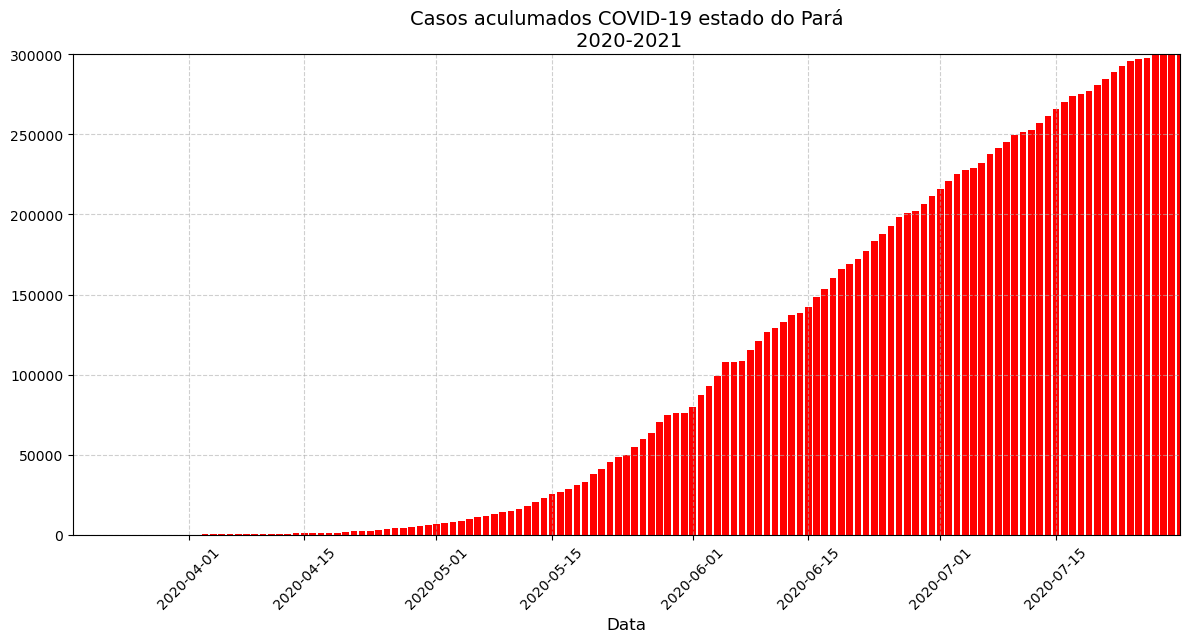

In [3]:
# Visualização
NCP=dfPA['new_confirmed'].values
NCB=dfbel['new_confirmed'].values

# casos acumulados
Cp=np.cumsum(NCP)
Cb=np.cumsum(NCB)

t_date=dfPA['date'].values

# periodo -01/02/2020 - 12/07/2020 (318)
yc=NCP[0:150]
y=Cp[0:150]
x=t_date[0:150] 

plt.figure(figsize=(12, 6))
plt.bar(x, y, color='red', label='Dados originais')
plt.title('Casos aculumados COVID-19 estado do Pará\n 2020-2021', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.tight_layout()
plt.ylim([0,300000])
plt.xlim(pd.to_datetime(['2020-03-18', '2020-07-30'])) 
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45);  # Rotaciona as datas para melhor legibilidade

In [4]:
#funções
def solve_sirc(y0,t,N,beta,gamma):
    """Resolve o modelo SIRC e retorna casos acumulados."""
    sol = odeint(model.SIRC, y0, t, args=(N, beta, gamma))
    return sol[:, 3]
    
def solve_sirc_inv(params,y0,t,N):
    """Resolve SIRC para problemas inversos com tolerâncias ajustadas."""
    beta = params['beta'].value
    gamma = params['gamma'].value
    sol = odeint(model.SIRC, y0, t, args=(N, beta, gamma))#,
               # rtol=1e-3, atol=1e-6, hmax=0.5, mxstep=5000)
    return sol

def residual(params,y0,t,N,data):
    """Calcula resíduos entre modelo e dados, com tratamento de NaN."""
    temp = solve_sirc_inv(params, y0, t, N)
    model=temp[:,3]
    #model = np.nan_to_num(temp[:, 3], nan=0.0, posinf=1.0, neginf=0.0)
    if np.isnan(model).any():
        print("⚠️ AVISO: NaN detectado com parâmetros:")
        print(f"beta: {params['beta'].value:.4f}")
        print(f"gamma: {params['gamma'].value:.4f}")
    return model - data

def SIRC_var(result,y0,t,N):
    """Extrai todas as variáveis do modelo SIRC ajustado."""
    sol = solve_sirc_inv(result.params, y0, t, N)
    return sol.T 

In [5]:
c = y                  #dados
N = 1000000            # População total (ajuste conforme necessário)
I0 = c[0]              # Infectados iniciais
C0 = I0
t = np.arange(len(c))  # tempo 
#
print('Io=',I0)
print('N=',N)

# Estimar chutes inicias e N
K,r,A = model.initial_SIRC(c)

I0 = K / (A + 1)      #infectados inicias
N = 2 * K             #populacao
gamma_i = 2 * r       #taxa de recuperacao
beta_i = 1.5 * gamma_i  #taxa de contagio

#N=700000
# ---------------------------
# PARÂMETROS INICIAIS
# ---------------------------
print('\n' + '='*40)
print('PARÂMETROS INICIAIS'.center(40))
print('='*40)
print(f'{"I0:":<10}{I0:>30.6f}')
print(f'{"N:":<10}{N:>30.6f}')
print(f'{"gamma_i:":<10}{gamma_i:>30.6f}')
print(f'{"beta_i:":<10}{beta_i:>30.6f}')
print(datetime.now().isoformat(timespec='seconds'))
# Configuração dos parâmetros
params = Parameters()
params.add('beta', value=beta_i, min=0.1, max=2.1)
params.add('gamma', value=gamma_i, min=0, max=1)

#---------------------------
#RESULTADOS DA OTIMIZAÇÃO
#---------------------------

R0 = 0
C0 = I0             # Casos acumulados iniciais = infectados iniciais
S0 = N  - I0 - R0
y0 = [S0, I0, R0, C0]
print('yo',y0)

# Levenberg-Marquardt
result_LM = minimize(residual, params, args=(y0,t, N,c))
print('\n' + '-'*40)
print('MÉTODO LEVENBERG-MARQUARDT (LM)'.center(40))
print('-'*40)
print(f'{"beta:":<10}{result_LM.params["beta"].value:>30.6f}')
print(f'{"gamma:":<10}{result_LM.params["gamma"].value:>30.6f}')
print(f"Avaliações da função: {result_LM.nfev }")
print(datetime.now().isoformat(timespec='seconds'))

# Nelder-Mead
result_NM = minimize(residual, params, args=(y0,t, N,c),method='Nelder-Mead')
print('\n' + '-'*40)
print('MÉTODO NELDER-MEAD (NM)'.center(40))
print('-'*40)
print(f'{"beta:":<10}{result_NM.params["beta"].value:>30.6f}')
print(f'{"gamma:":<10}{result_NM.params["gamma"].value:>30.6f}')
print(f"Avaliações da função: {result_NM.nfev }")
print(datetime.now().isoformat(timespec='seconds'))

# Least Squares
result_MQ = minimize(residual, params, args=(y0,t, N,c),method='least_squares')
print('\n' + '-'*40)
print('MÉTODO LEAST SQUARES MQ'.center(40))
print('-'*40)
print(f'{"beta:":<10}{result_MQ.params["beta"].value:>30.6f}')
print(f'{"gamma:":<10}{result_MQ.params["gamma"].value:>30.6f}')
print(f"Avaliações da função: {result_MQ.nfev }")
print(datetime.now().isoformat(timespec='seconds'))

# L-BFGS-B
result_lbfgsb = minimize(residual, params, args=(y0,t, N,c),method='lbfgsb')
print('\n' + '-'*40)
print('MÉTODO L-BFGS-B (lbfgsb)'.center(40))
print('-'*40)
print(f'{"beta:":<10}{result_lbfgsb.params["beta"].value:>30.6f}')
print(f'{"gamma:":<10}{result_lbfgsb.params["gamma"].value:>30.6f}')
print(f"Avaliações da função: {result_lbfgsb.nfev }")
print(datetime.now().isoformat(timespec='seconds'))

# NEWTON
result_NW = minimize(residual, params, args=(y0,t, N,c),method='tnc')
print('\n' + '-'*40)
print('MÉTODO NEWTON (NW)'.center(40))
print('-'*40)
print(f'{"beta:":<10}{result_NW.params["beta"].value:>30.6f}')
print(f'{"gamma:":<10}{result_NW.params["gamma"].value:>30.6f}')
print(f"Avaliações da função: {result_NW.nfev }")
print(datetime.now().isoformat(timespec='seconds'))
print('='*40)

print(datetime.now().isoformat(timespec='seconds'))

Io= 2
N= 1000000

          PARÂMETROS INICIAIS           
I0:                             1.728745
N:                         708093.675215
gamma_i:                        0.291505
beta_i:                         0.437257
2025-05-22T14:07:46
yo [708091.9464699875, 1.7287449368636383, 0, 1.7287449368636383]

----------------------------------------
    MÉTODO LEVENBERG-MARQUARDT (LM)     
----------------------------------------
beta:                           0.513974
gamma:                          0.395416
Avaliações da função: 58
2025-05-22T14:07:46

----------------------------------------
        MÉTODO NELDER-MEAD (NM)         
----------------------------------------
beta:                           0.513867
gamma:                          0.395316
Avaliações da função: 257
2025-05-22T14:07:46

----------------------------------------
        MÉTODO LEAST SQUARES MQ         
----------------------------------------
beta:                           0.513866
gamma:                 

2025-05-22T14:13:37
[[Fit Statistics]]
    # fitting method   = TNC
    # function evals   = 243
    # data points      = 150
    # variables        = 2
    chi-square         = 7.0351e+10
    reduced chi-square = 4.7535e+08
    Akaike info crit   = 2998.91947
    Bayesian info crit = 3004.94074
[[Variables]]
    beta:   0.51381383 +/- 0.00993848 (1.93%) (init = 0.4372568)
    gamma:  0.39526570 +/- 0.00933428 (2.36%) (init = 0.2915045)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) = +0.9977


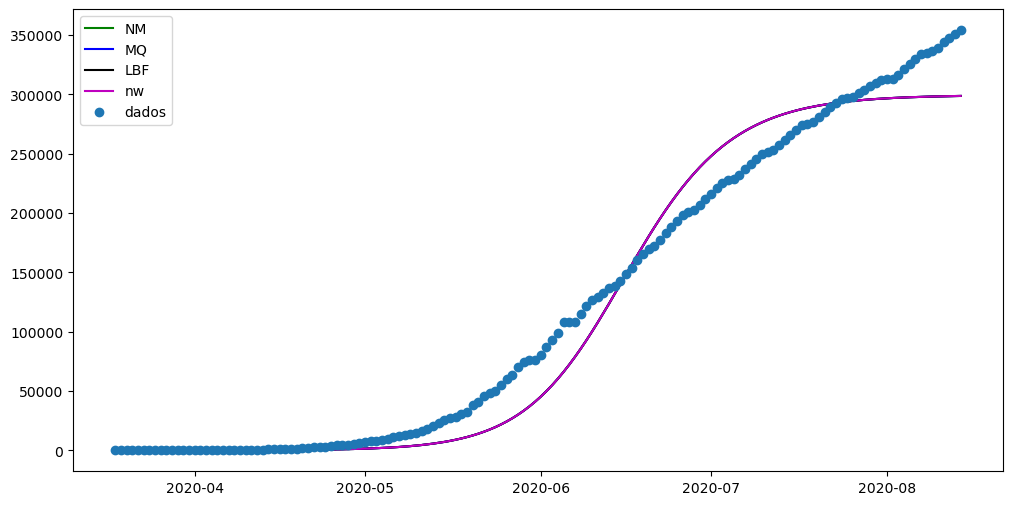

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
c_lm = c + result_LM.residual
c_nm = c + result_NM.residual
c_mq = c + result_MQ.residual
c_lbf = c +result_lbfgsb.residual
c_nw = c + result_NW.residual

plt.plot(x,c_nm,'g',label='NM')
plt.plot(x,c_mq,'b',label='MQ')
plt.plot(x,c_lbf,'k',label='LBF')
plt.plot(x,c_nw,'m',label='nw')
ax.plot(x,y,'o',label='dados')
plt.legend()
print(datetime.now().isoformat(timespec='seconds'))
print(fit_report(result_NW))
